In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Loading the datasets

In [2]:
# Loading the datasets and making the date the index of the dataframe
df = pd.read_csv("raw_toronto_weather_data 1.csv", index_col="date")
df = df.sort_values(by='date')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 10021 entries, 1996-12-30 to 2024-06-06
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   max_temperature                10021 non-null  float64
 1   avg_hourly_temperature         10021 non-null  float64
 2   avg_temperature                10021 non-null  float64
 3   min_temperature                10021 non-null  float64
 4   max_humidex                    2823 non-null   float64
 5   min_windchill                  3308 non-null   float64
 6   max_relative_humidity          10021 non-null  int64  
 7   avg_hourly_relative_humidity   10021 non-null  float64
 8   avg_relative_humidity          10021 non-null  float64
 9   min_relative_humidity          10021 non-null  int64  
 10  max_dew_point                  10021 non-null  float64
 11  avg_hourly_dew_point           10021 non-null  float64
 12  avg_dew_point                  10021 

,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,min_relative_humidity,...,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
date,,,,,,,,,,,,,,,,,,,,,
1996-12-30,-2.0,-5.63,-4.84,-7.7,NaN,-15.0,86,75.9,71.0,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-12-31,-7.3,-11.12,-11.00,-14.7,NaN,-23.0,90,77.2,77.5,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-01,-3.0,-7.96,-8.80,-14.6,NaN,-22.0,98,91.4,91.0,84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-02,4.1,0.95,0.44,-3.2,NaN,-4.0,100,97.8,96.5,93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-03,5.6,2.95,3.40,1.2,NaN,NaN,100,90.8,91.0,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Removing the first two rows of year 1996
df = df.drop(df.index[:2])  # Removes the first two rows
df.shape

(10019, 71)

### Preprocessing

1. Handling missing values
2. Cleaning the data
3. Splitting the data into training and testing sets

In [4]:
# Finding missing rows
df[df.isnull().any(axis=1)]

,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,min_relative_humidity,...,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
date,,,,,,,,,,,,,,,,,,,,,
1997-01-01,-3.0,-7.96,-8.80,-14.6,NaN,-22.0,98,91.4,91.0,84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-02,4.1,0.95,0.44,-3.2,NaN,-4.0,100,97.8,96.5,93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-03,5.6,2.95,3.40,1.2,NaN,NaN,100,90.8,91.0,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-04,3.4,2.35,2.20,1.0,NaN,NaN,100,91.6,91.0,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-05,10.1,3.48,4.20,-1.7,NaN,-9.0,100,86.5,83.0,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02,18.2,16.21,16.30,14.4,NaN,NaN,100,82.8,74.5,49,...,NaN,NaN,8.0,7.8,6.5,5.0,NaN,NaN,NaN,NaN
2024-06-03,23.4,18.42,19.54,15.7,29.0,NaN,100,90.8,85.5,71,...,NaN,NaN,8.0,4.5,4.0,0.0,NaN,NaN,NaN,NaN
2024-06-04,26.8,21.17,21.05,15.3,33.0,NaN,99,75.8,79.5,60,...,NaN,NaN,8.0,4.8,4.0,0.0,NaN,NaN,NaN,NaN


In [5]:
# Checking for the number of missing values before data cleaning
df.isna().sum()

max_temperature                 0
avg_hourly_temperature          0
avg_temperature                 0
min_temperature                 0
max_humidex                  7196
                             ... 
min_cloud_cover_8            6125
max_cloud_cover_10           9782
avg_hourly_cloud_cover_10    9782
avg_cloud_cover_10           9782
min_cloud_cover_10           9782
Length: 71, dtype: int64

In [6]:
# Calculating the percentage of null values  
null_pct =  round(df.isna().sum()*100 / len(df), 2)
null_pct

max_temperature               0.00
avg_hourly_temperature        0.00
avg_temperature               0.00
min_temperature               0.00
max_humidex                  71.82
                             ...  
min_cloud_cover_8            61.13
max_cloud_cover_10           97.63
avg_hourly_cloud_cover_10    97.63
avg_cloud_cover_10           97.63
min_cloud_cover_10           97.63
Length: 71, dtype: float64

In [7]:
# Getting columns with less than 40% missing values
valid_cols = df.columns[null_pct < .40]
valid_cols

Index(['max_temperature', 'avg_hourly_temperature', 'avg_temperature',
       'min_temperature', 'max_relative_humidity',
       'avg_hourly_relative_humidity', 'avg_relative_humidity',
       'min_relative_humidity', 'max_dew_point', 'avg_hourly_dew_point',
       'avg_dew_point', 'min_dew_point', 'max_wind_speed',
       'avg_hourly_wind_speed', 'avg_wind_speed', 'min_wind_speed',
       'max_pressure_sea', 'avg_hourly_pressure_sea', 'avg_pressure_sea',
       'min_pressure_sea', 'max_pressure_station',
       'avg_hourly_pressure_station', 'avg_pressure_station',
       'min_pressure_station', 'max_visibility', 'avg_hourly_visibility',
       'avg_visibility', 'min_visibility', 'heatdegdays', 'cooldegdays',
       'growdegdays_5', 'growdegdays_7', 'growdegdays_10', 'precipitation',
       'rain', 'snow'],
      dtype='object')

In [8]:
# Assigning the valid columns only to df
df = df[valid_cols].copy()

In [9]:
# Checking for the number of missing values before cleaning
df.isna().sum()

max_temperature                  0
avg_hourly_temperature           0
avg_temperature                  0
min_temperature                  0
max_relative_humidity            0
avg_hourly_relative_humidity     0
avg_relative_humidity            0
min_relative_humidity            0
max_dew_point                    0
avg_hourly_dew_point             0
avg_dew_point                    0
min_dew_point                    0
max_wind_speed                   0
avg_hourly_wind_speed            0
avg_wind_speed                   0
min_wind_speed                   0
max_pressure_sea                 0
avg_hourly_pressure_sea          0
avg_pressure_sea                 0
min_pressure_sea                 0
max_pressure_station             0
avg_hourly_pressure_station      0
avg_pressure_station             0
min_pressure_station             0
max_visibility                   0
avg_hourly_visibility            0
avg_visibility                   0
min_visibility                   0
heatdegdays         

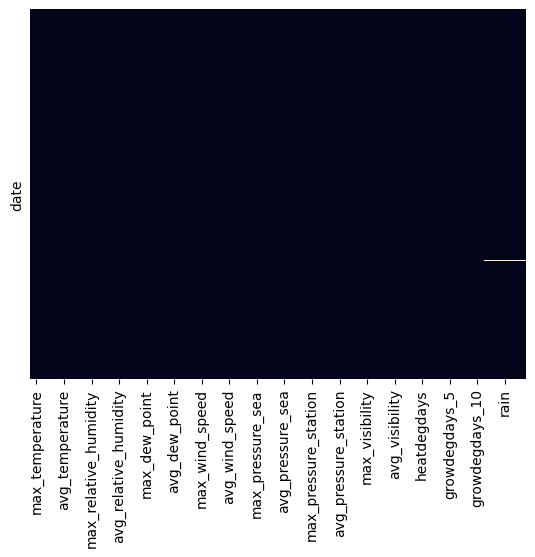

In [10]:
# Missing Data heatmap before cleaning
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='rocket')
plt.show()

In [11]:
# Filling in the missing values for precipitation, rain and snow
df = df.ffill()

In [12]:
# Checking for the number of missing values post-cleaning
df.isna().sum()

max_temperature                 0
avg_hourly_temperature          0
avg_temperature                 0
min_temperature                 0
max_relative_humidity           0
avg_hourly_relative_humidity    0
avg_relative_humidity           0
min_relative_humidity           0
max_dew_point                   0
avg_hourly_dew_point            0
avg_dew_point                   0
min_dew_point                   0
max_wind_speed                  0
avg_hourly_wind_speed           0
avg_wind_speed                  0
min_wind_speed                  0
max_pressure_sea                0
avg_hourly_pressure_sea         0
avg_pressure_sea                0
min_pressure_sea                0
max_pressure_station            0
avg_hourly_pressure_station     0
avg_pressure_station            0
min_pressure_station            0
max_visibility                  0
avg_hourly_visibility           0
avg_visibility                  0
min_visibility                  0
heatdegdays                     0
cooldegdays   

In [13]:
# Getting a Statistical Summary of the data
df.describe(include="all")

,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,min_relative_humidity,max_dew_point,avg_hourly_dew_point,...,avg_visibility,min_visibility,heatdegdays,cooldegdays,growdegdays_5,growdegdays_7,growdegdays_10,precipitation,rain,snow
count,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,...,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000
mean,13.630752,9.143915,9.010631,4.392035,85.401637,69.332628,69.030342,52.659048,6.523206,3.346003,...,19789.799381,14947.509732,10.027927,1.038677,6.749805,5.573540,4.027478,2.160196,1.859158,0.320830
std,11.315122,10.480384,10.545357,10.042189,10.221874,12.286544,11.172906,14.556967,9.682561,9.960977,...,5173.366838,8906.128122,9.247519,2.201631,7.208566,6.469344,5.293412,5.388539,5.191014,1.532879
min,-19.100000,-21.950000,-22.300000,-26.300000,38.000000,27.700000,29.500000,13.000000,-24.800000,-28.100000,...,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.930000,0.840000,-2.600000,79.000000,61.300000,61.500000,42.000000,-0.900000,-4.200000,...,15250.000000,6400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,9.150000,9.050000,4.300000,87.000000,69.700000,69.500000,52.000000,6.800000,3.300000,...,20700.000000,16100.000000,8.900000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,23.600000,18.520000,18.390000,13.100000,93.000000,77.700000,77.000000,62.500000,14.800000,11.800000,...,24100.000000,24100.000000,17.200000,0.400000,13.400000,11.400000,8.400000,1.400000,0.600000,0.000000
max,37.900000,31.700000,31.950000,26.300000,100.000000,100.000000,100.000000,100.000000,26.200000,24.400000,...,52300.000000,25000.000000,40.300000,13.900000,26.900000,24.900000,21.900000,126.000000,126.000000,30.400000


In [14]:
# Checking the data types of the attributes
df.dtypes

max_temperature                 float64
avg_hourly_temperature          float64
avg_temperature                 float64
min_temperature                 float64
max_relative_humidity             int64
avg_hourly_relative_humidity    float64
avg_relative_humidity           float64
min_relative_humidity             int64
max_dew_point                   float64
avg_hourly_dew_point            float64
avg_dew_point                   float64
min_dew_point                   float64
max_wind_speed                    int64
avg_hourly_wind_speed           float64
avg_wind_speed                  float64
min_wind_speed                    int64
max_pressure_sea                float64
avg_hourly_pressure_sea         float64
avg_pressure_sea                float64
min_pressure_sea                float64
max_pressure_station            float64
avg_hourly_pressure_station     float64
avg_pressure_station            float64
min_pressure_station            float64
max_visibility                    int64


In [15]:
# Checking the datatype of the index (i.e. the dates)
df.index

Index(['1997-01-01', '1997-01-02', '1997-01-03', '1997-01-04', '1997-01-05',
       '1997-01-06', '1997-01-07', '1997-01-08', '1997-01-09', '1997-01-10',
       ...
       '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01',
       '2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06'],
      dtype='object', name='date', length=10019)

In [16]:
# Converting the index datatype from object to date
df.index = pd.to_datetime(df.index)

In [17]:
df.index

DatetimeIndex(['1997-01-01', '1997-01-02', '1997-01-03', '1997-01-04',
               '1997-01-05', '1997-01-06', '1997-01-07', '1997-01-08',
               '1997-01-09', '1997-01-10',
               ...
               '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31',
               '2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04',
               '2024-06-05', '2024-06-06'],
              dtype='datetime64[ns]', name='date', length=10019, freq=None)

In [18]:
# Checking the data according to the years
df.index.year.value_counts().sort_index()

date
1997    365
1998    365
1999    365
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024    158
Name: count, dtype: int64

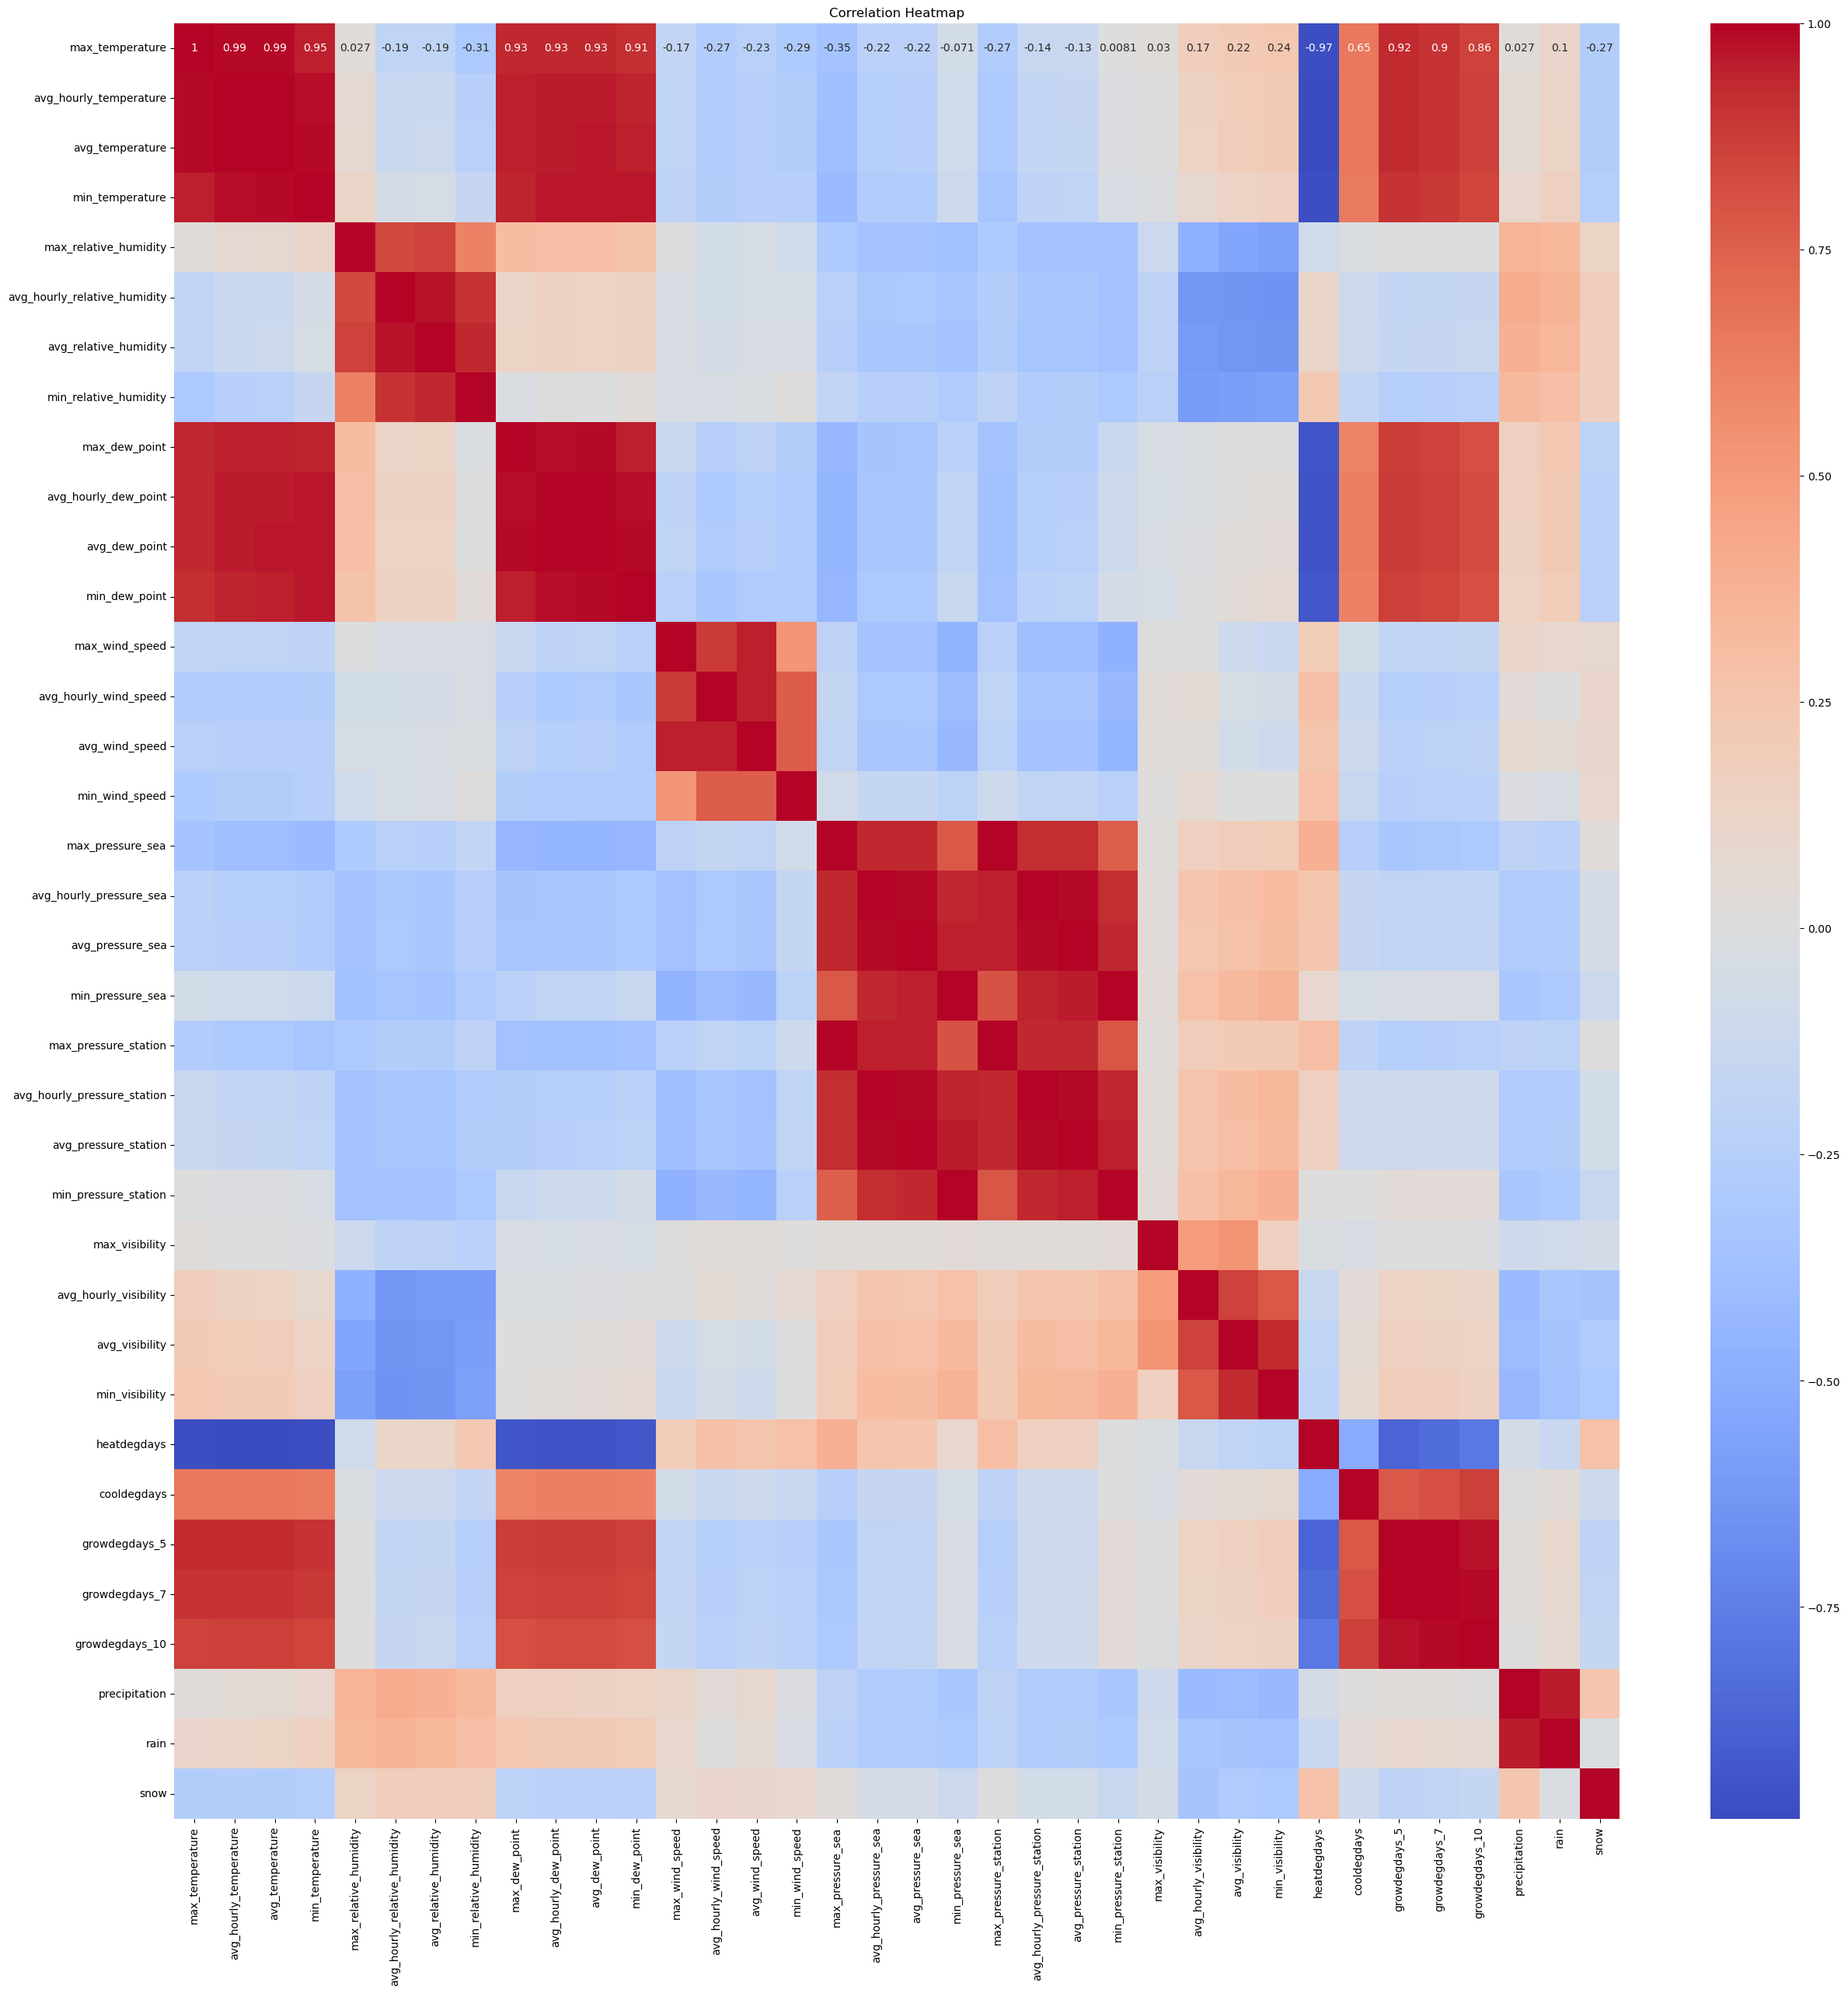

In [19]:
# Correlation heatmap
plt.figure(figsize=(30, 30))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

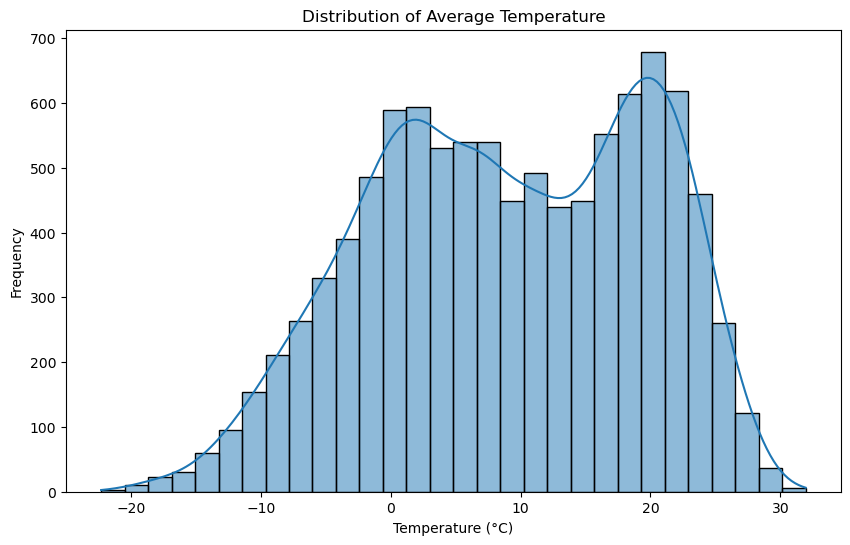

In [20]:
# Histogram for temperature
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_temperature'], bins=30, kde=True)
plt.title('Distribution of Average Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

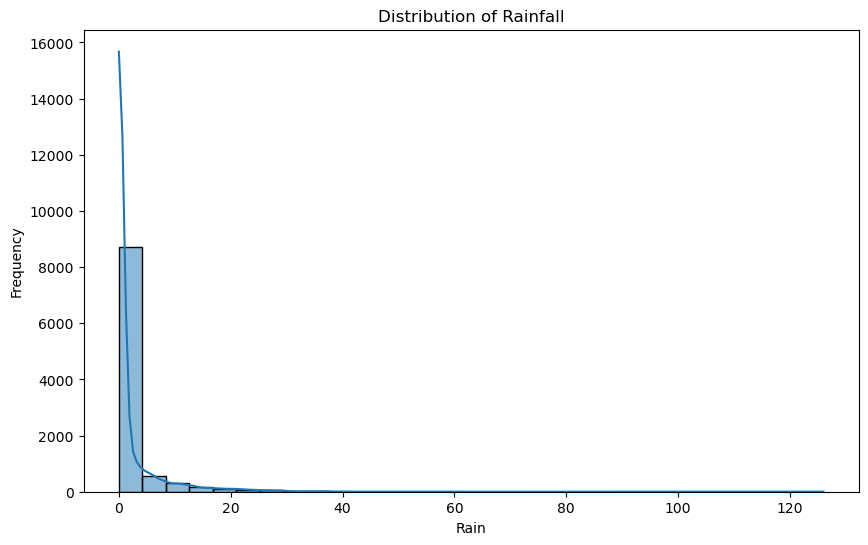

In [21]:
# Histogram for rain
plt.figure(figsize=(10, 6))
sns.histplot(df['rain'], bins=30, kde=True)
plt.title('Distribution of Rainfall')
plt.xlabel('Rain')
plt.ylabel('Frequency')
plt.show()

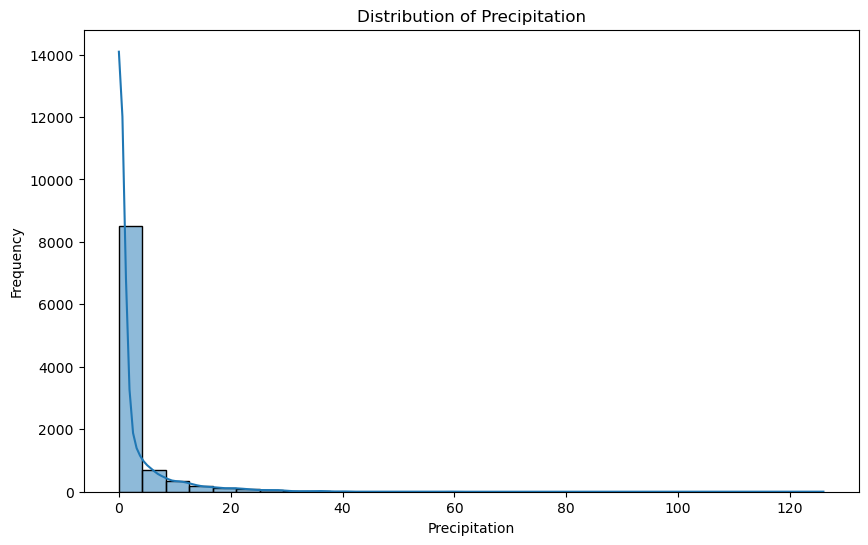

In [22]:
# Histogram for precipitation
plt.figure(figsize=(10, 6))
sns.histplot(df['precipitation'], bins=30, kde=True)
plt.title('Distribution of Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()

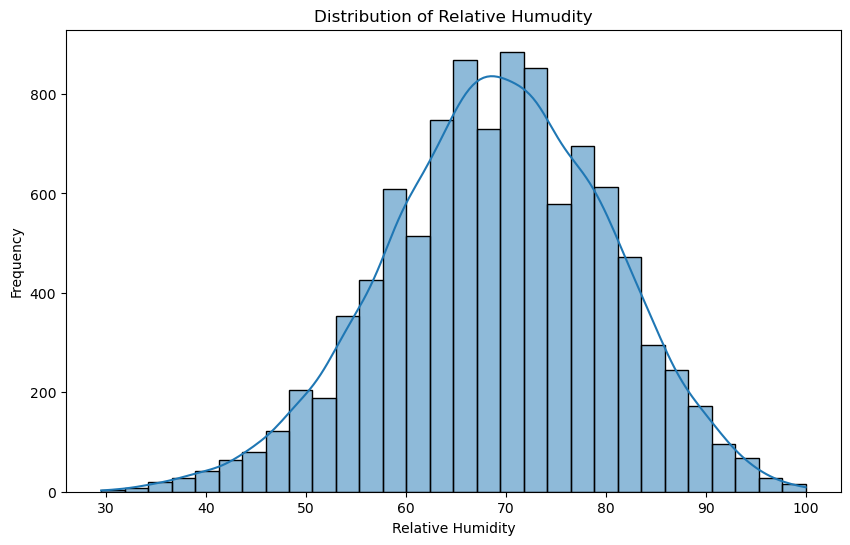

In [23]:
# Histogram for relative humidity
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_relative_humidity'], bins=30, kde=True)
plt.title('Distribution of Relative Humudity')
plt.xlabel('Relative Humidity')
plt.ylabel('Frequency')
plt.show()

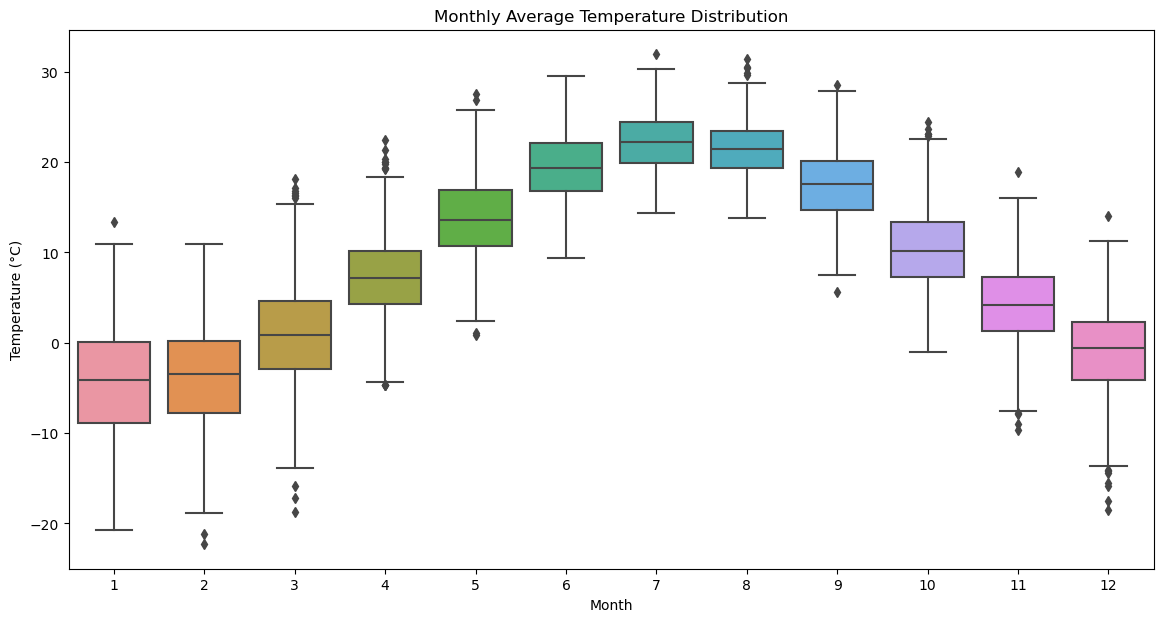

In [24]:
# Box plot for temperature by month
df['month'] = df.index.month
plt.figure(figsize=(14, 7))
sns.boxplot(x='month', y='avg_temperature', data=df)
plt.title('Monthly Average Temperature Distribution')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.show()

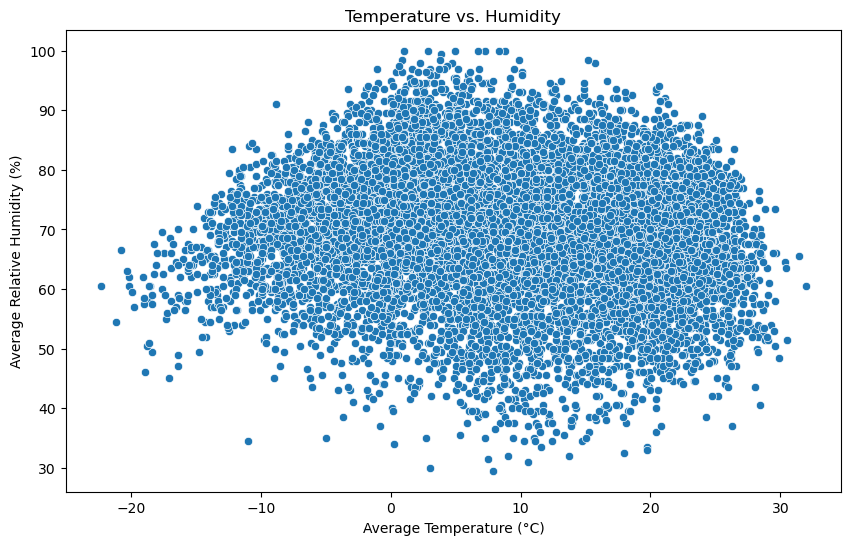

In [25]:
# Scatter plot for temperature vs. humidity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_temperature', y='avg_relative_humidity', data=df)
plt.title('Temperature vs. Humidity')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Average Relative Humidity (%)')
plt.show()

<Axes: xlabel='date'>

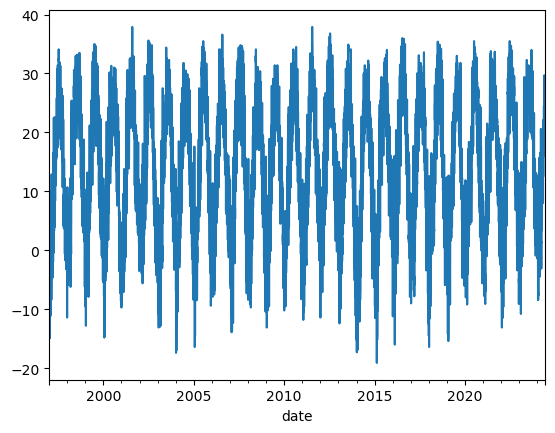

In [26]:
df['max_temperature'].plot()

<Axes: xlabel='date'>

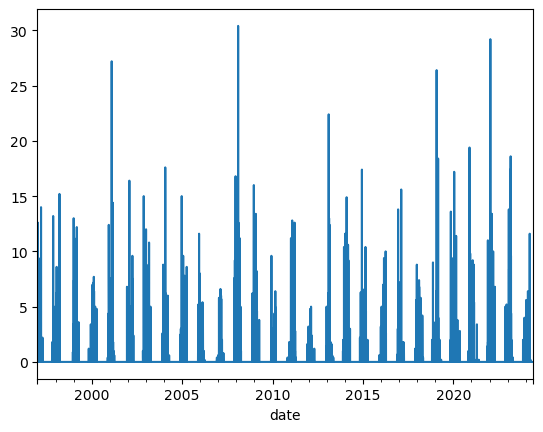

In [27]:
df['snow'].plot()

<Axes: xlabel='date'>

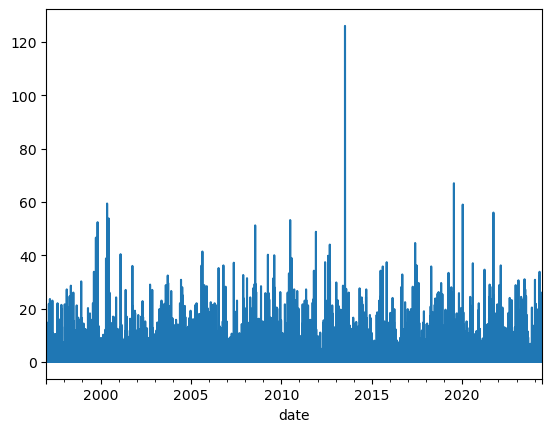

In [28]:
df['precipitation'].plot()

<Axes: xlabel='date'>

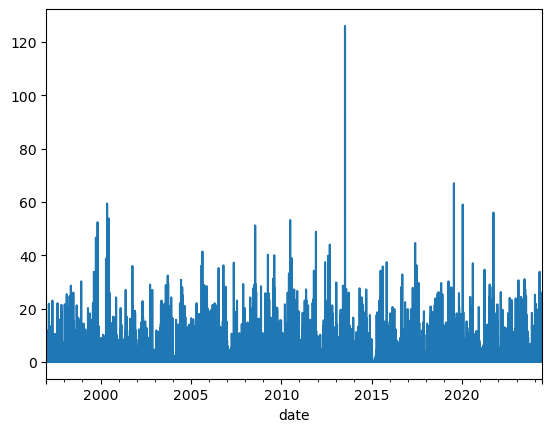

In [29]:
df['rain'].plot()

<Axes: xlabel='date'>

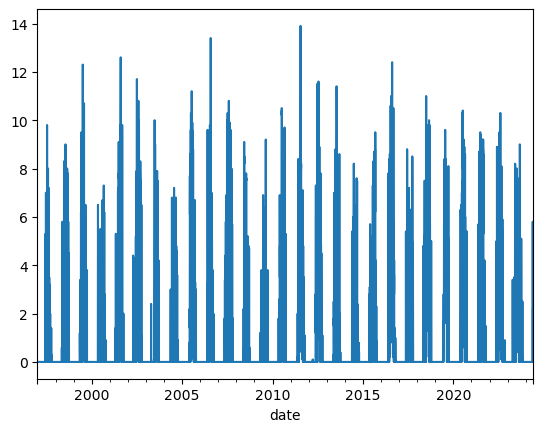

In [30]:
df['cooldegdays'].plot()

<Axes: xlabel='date'>

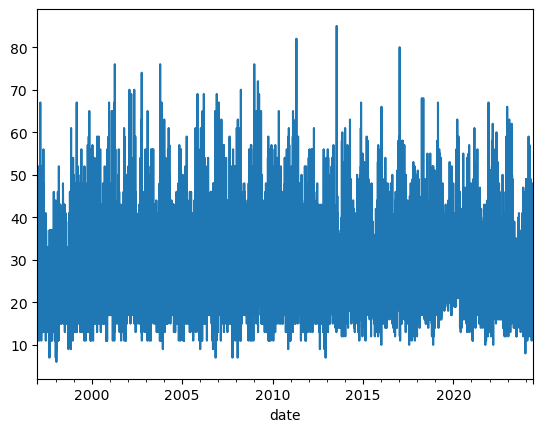

In [31]:
df['max_wind_speed'].plot()

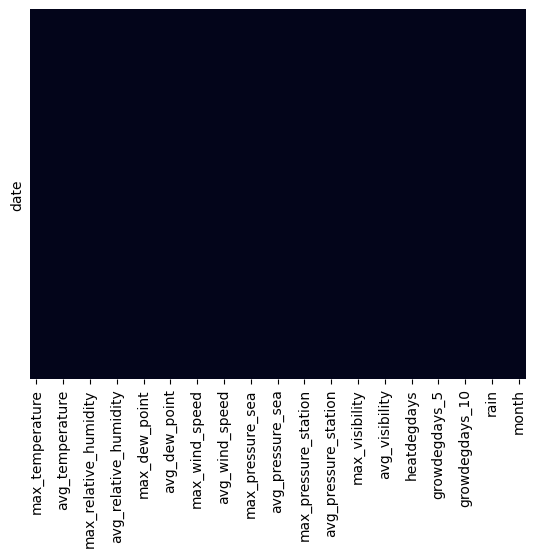

In [32]:
# Missing Data heatmap post-cleaning
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='rocket')
plt.show()

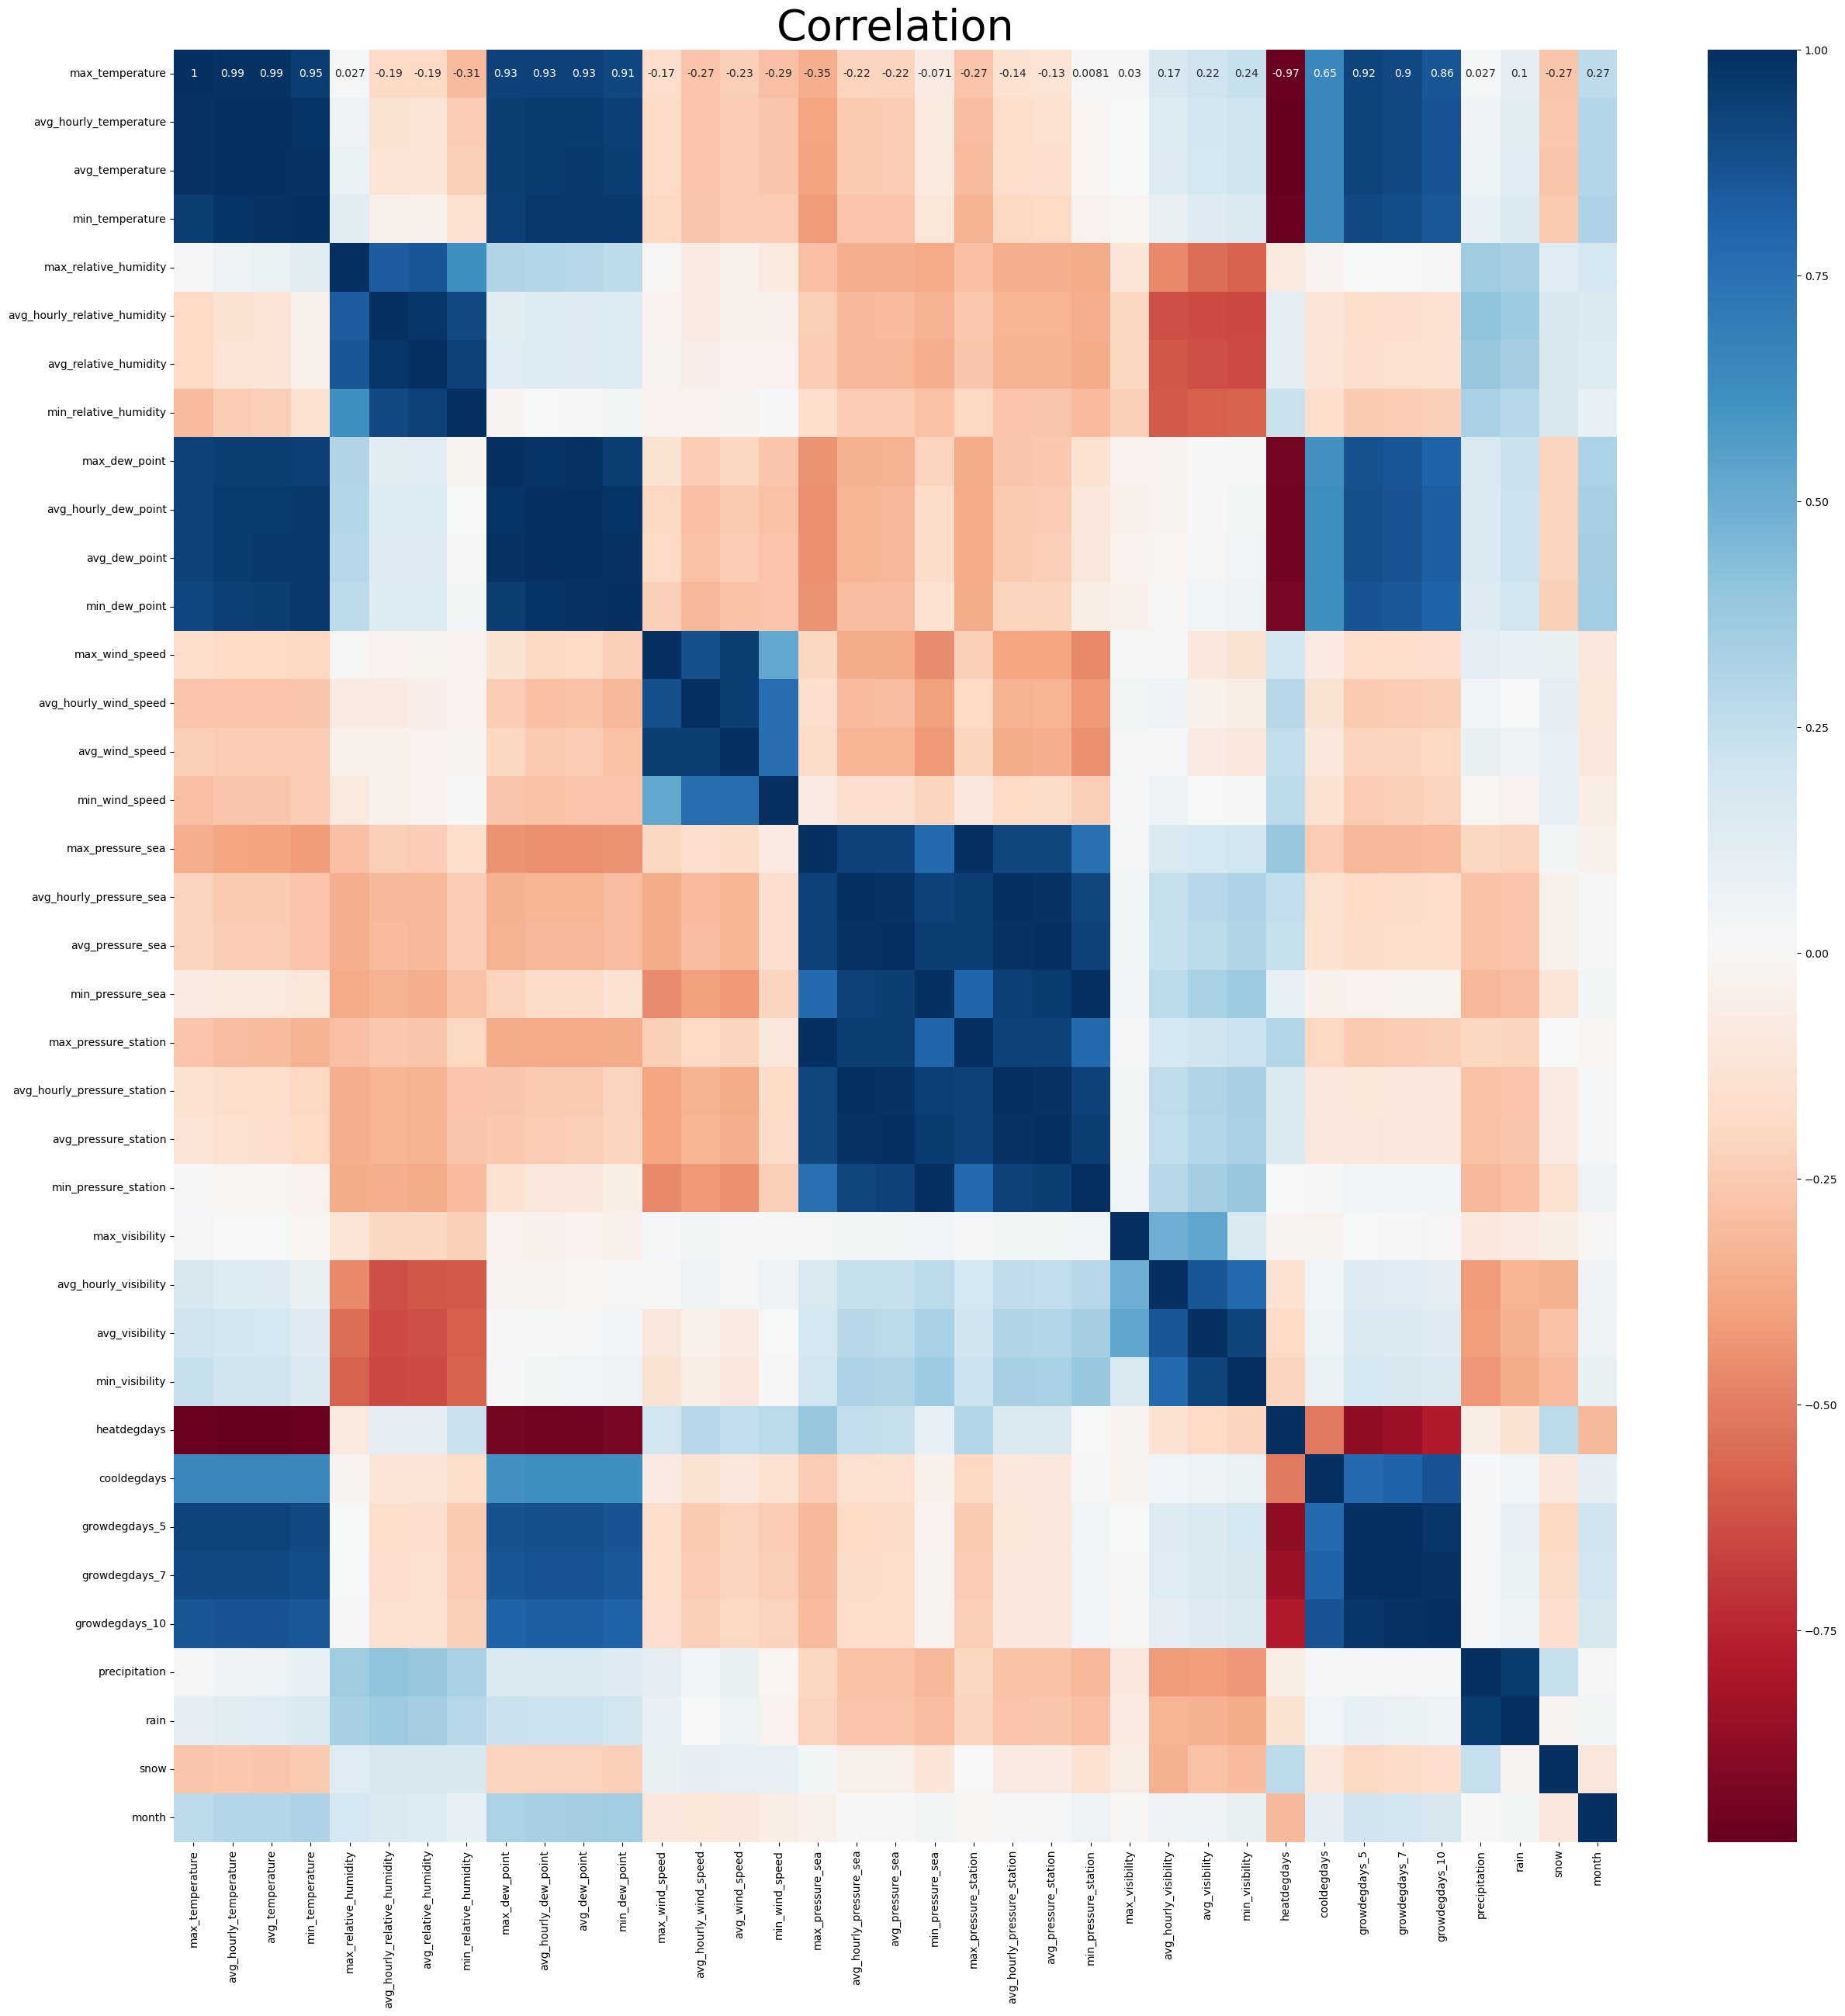

In [33]:
# Correlation plot 
plt.figure(figsize=(30,30))
sns.heatmap(df.select_dtypes(include=['number']).corr(),annot=True,cmap='RdBu')

plt.title("Correlation",fontsize=40)
plt.show()

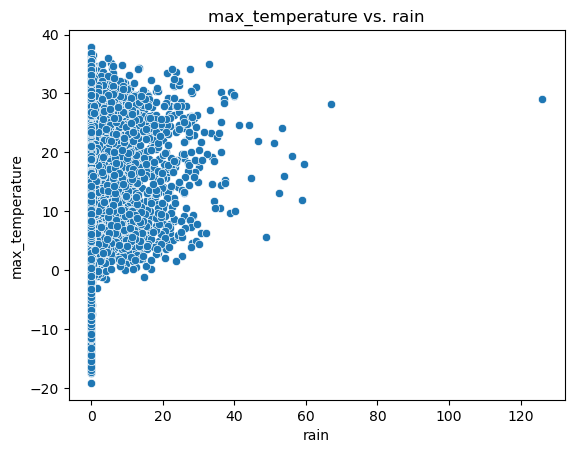

Pearson correlation: 0.1013026823889822


In [34]:
# Scatter Plot for max_temperature vs rain
sns.scatterplot(x='rain', y='max_temperature', data=df)
plt.title('max_temperature vs. rain')
plt.show()

# Pearson Correlation Coefficient
correlation, _ = pearsonr(df['rain'], df['max_temperature'])
print(f'Pearson correlation: {correlation}')

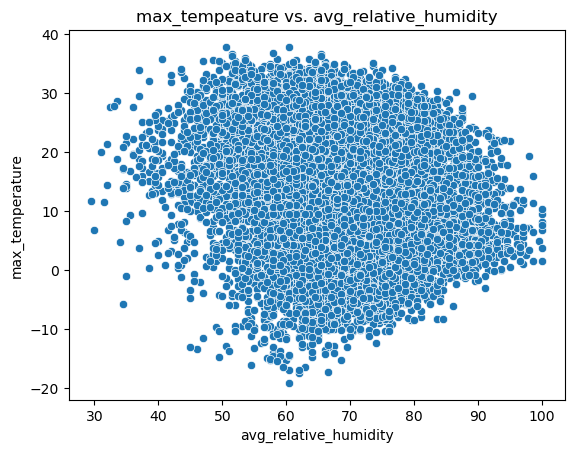

Pearson correlation: -0.18860673181518917


In [35]:
# Scatter Plot for max_tempeature vs avg_relative_humidity
sns.scatterplot(x='avg_relative_humidity', y='max_temperature', data=df)
plt.title('max_tempeature vs. avg_relative_humidity')
plt.show()

# Pearson Correlation Coefficient
correlation, _ = pearsonr(df['max_temperature'], df['avg_relative_humidity'])
print(f'Pearson correlation: {correlation}')

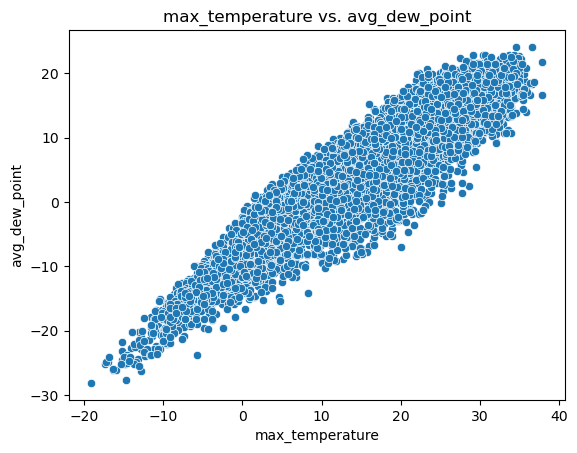

Pearson correlation: 0.9333212084360306


In [36]:
# Scatter Plot for max_temperature vs avg_dew_point
sns.scatterplot(x='max_temperature', y='avg_dew_point', data=df)
plt.title('max_temperature vs. avg_dew_point')
plt.show()

# Pearson Correlation Coefficient
correlation, _ = pearsonr(df['max_temperature'], df['avg_dew_point'])
print(f'Pearson correlation: {correlation}')

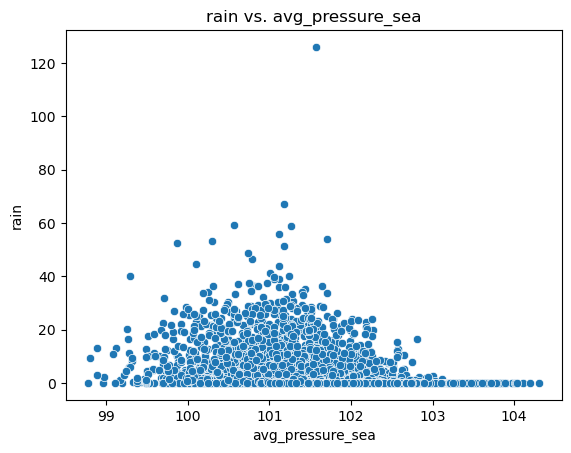

Pearson correlation: -0.27634540616698067


In [37]:
# Scatter Plot for rain vs avg_pressure_sea
sns.scatterplot(x='avg_pressure_sea', y='rain', data=df)
plt.title('rain vs. avg_pressure_sea')
plt.show()

# Pearson Correlation Coefficient
correlation, _ = pearsonr(df['avg_pressure_sea'], df['rain'])
print(f'Pearson correlation: {correlation}')

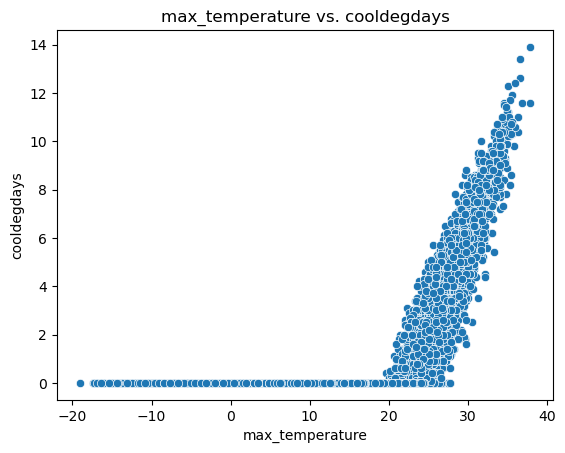

Pearson correlation: 0.6514285642421178


In [38]:
# Scatter Plot for max_temperature vs cooldegdays
sns.scatterplot(x='max_temperature', y='cooldegdays', data=df)
plt.title('max_temperature vs. cooldegdays')
plt.show()

# Pearson Correlation Coefficient
correlation, _ = pearsonr(df['max_temperature'], df['cooldegdays'])
print(f'Pearson correlation: {correlation}')

### Modeling

In [39]:
# Setting the next day's max_temperature value as the target of the current day's features
df['y'] = df.shift(-1)['max_temperature']

In [40]:
df

,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,min_relative_humidity,max_dew_point,avg_hourly_dew_point,...,heatdegdays,cooldegdays,growdegdays_5,growdegdays_7,growdegdays_10,precipitation,rain,snow,month,y
date,,,,,,,,,,,,,,,,,,,,,
1997-01-01,-3.0,-7.96,-8.80,-14.6,98,91.4,91.0,84,-3.6,-9.1,...,26.8,0.0,0.0,0.0,0.0,4.0,0.0,4.0,1,4.1
1997-01-02,4.1,0.95,0.44,-3.2,100,97.8,96.5,93,3.1,0.6,...,17.6,0.0,0.0,0.0,0.0,1.4,1.4,0.0,1,5.6
1997-01-03,5.6,2.95,3.40,1.2,100,90.8,91.0,82,5.2,1.6,...,14.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.4
1997-01-04,3.4,2.35,2.20,1.0,100,91.6,91.0,82,3.3,1.1,...,15.8,0.0,0.0,0.0,0.0,4.2,4.2,0.0,1,10.1
1997-01-05,10.1,3.48,4.20,-1.7,100,86.5,83.0,66,8.3,1.3,...,13.8,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1,-1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02,18.2,16.21,16.30,14.4,100,82.8,74.5,49,17.0,12.9,...,1.7,0.0,11.3,9.3,6.3,7.0,7.0,0.0,6,23.4
2024-06-03,23.4,18.42,19.54,15.7,100,90.8,85.5,71,20.3,16.8,...,0.0,1.5,14.5,12.5,9.5,0.0,0.0,0.0,6,26.8
2024-06-04,26.8,21.17,21.05,15.3,99,75.8,79.5,60,19.1,16.5,...,0.0,3.0,16.1,14.1,11.1,0.0,0.0,0.0,6,25.6


In [41]:
# Handling the last row missing the target data
df = df.ffill()

In [42]:
df

,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,min_relative_humidity,max_dew_point,avg_hourly_dew_point,...,heatdegdays,cooldegdays,growdegdays_5,growdegdays_7,growdegdays_10,precipitation,rain,snow,month,y
date,,,,,,,,,,,,,,,,,,,,,
1997-01-01,-3.0,-7.96,-8.80,-14.6,98,91.4,91.0,84,-3.6,-9.1,...,26.8,0.0,0.0,0.0,0.0,4.0,0.0,4.0,1,4.1
1997-01-02,4.1,0.95,0.44,-3.2,100,97.8,96.5,93,3.1,0.6,...,17.6,0.0,0.0,0.0,0.0,1.4,1.4,0.0,1,5.6
1997-01-03,5.6,2.95,3.40,1.2,100,90.8,91.0,82,5.2,1.6,...,14.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.4
1997-01-04,3.4,2.35,2.20,1.0,100,91.6,91.0,82,3.3,1.1,...,15.8,0.0,0.0,0.0,0.0,4.2,4.2,0.0,1,10.1
1997-01-05,10.1,3.48,4.20,-1.7,100,86.5,83.0,66,8.3,1.3,...,13.8,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1,-1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02,18.2,16.21,16.30,14.4,100,82.8,74.5,49,17.0,12.9,...,1.7,0.0,11.3,9.3,6.3,7.0,7.0,0.0,6,23.4
2024-06-03,23.4,18.42,19.54,15.7,100,90.8,85.5,71,20.3,16.8,...,0.0,1.5,14.5,12.5,9.5,0.0,0.0,0.0,6,26.8
2024-06-04,26.8,21.17,21.05,15.3,99,75.8,79.5,60,19.1,16.5,...,0.0,3.0,16.1,14.1,11.1,0.0,0.0,0.0,6,25.6


### Using the Ridge Regression Model

In [43]:
# Checking the correlation between the target and the features
df.corr()

,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,min_relative_humidity,max_dew_point,avg_hourly_dew_point,...,heatdegdays,cooldegdays,growdegdays_5,growdegdays_7,growdegdays_10,precipitation,rain,snow,month,y
max_temperature,1.000000,0.989004,0.989004,0.950527,0.027333,-0.192890,-0.188607,-0.308716,0.933503,0.932883,...,-0.972667,0.651429,0.924878,0.901518,0.859081,0.027299,0.101303,-0.268868,0.270073,0.927880
avg_hourly_temperature,0.989004,1.000000,0.997628,0.981032,0.063368,-0.136254,-0.128796,-0.242207,0.949732,0.959909,...,-0.982135,0.652993,0.926195,0.903849,0.862624,0.051095,0.124014,-0.262688,0.296015,0.930555
avg_temperature,0.989004,0.997628,1.000000,0.986016,0.071547,-0.125816,-0.120829,-0.235720,0.950102,0.960796,...,-0.983774,0.657466,0.927268,0.904992,0.864283,0.057854,0.131066,-0.263320,0.295486,0.930185
min_temperature,0.950527,0.981032,0.986016,1.000000,0.119496,-0.046906,-0.041258,-0.147244,0.943749,0.966910,...,-0.970362,0.646838,0.905461,0.884988,0.847292,0.090772,0.161167,-0.250135,0.316347,0.908248
max_relative_humidity,0.027333,0.063368,0.071547,0.119496,1.000000,0.837028,0.857901,0.614731,0.307957,0.295843,...,-0.085951,-0.018506,0.012932,0.009350,0.003303,0.362622,0.338861,0.128348,0.184884,-0.024880
avg_hourly_relative_humidity,-0.192890,-0.136254,-0.125816,-0.046906,0.837028,1.000000,0.971945,0.904234,0.121739,0.143392,...,0.115042,-0.119546,-0.163160,-0.157998,-0.150033,0.407994,0.371475,0.178007,0.151327,-0.214626
avg_relative_humidity,-0.188607,-0.128796,-0.120829,-0.041258,0.857901,0.971945,1.000000,0.932643,0.127504,0.143053,...,0.109676,-0.118115,-0.158784,-0.153300,-0.145361,0.381645,0.345622,0.172243,0.142302,-0.210255
min_relative_humidity,-0.308716,-0.242207,-0.235720,-0.147244,0.614731,0.904234,0.932643,1.000000,-0.020520,0.011855,...,0.228715,-0.168318,-0.252824,-0.241889,-0.225457,0.331215,0.292603,0.174277,0.088616,-0.305284
max_dew_point,0.933503,0.949732,0.950102,0.943749,0.307957,0.121739,0.127504,-0.020520,1.000000,0.983736,...,-0.938001,0.610683,0.874464,0.852964,0.812578,0.168162,0.231609,-0.214667,0.323504,0.853536
avg_hourly_dew_point,0.932883,0.959909,0.960796,0.966910,0.295843,0.143392,0.143053,0.011855,0.983736,1.000000,...,-0.947515,0.621960,0.882097,0.861660,0.823253,0.157889,0.222395,-0.219858,0.340616,0.869052


In [44]:
# Initializing the Ridge Regression Model
ridge_reg = Ridge(alpha = .1)

In [45]:
# Creating a list of predictor columns
X = df.columns[~df.columns.isin(['y'])]

In [46]:
# Time-series Cross Validation
def backtest(df, model, X, start=3650, step=90):
    all_predictions = []
    
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]
        
        model.fit(train[X], train['y'])
        
        preds = model.predict(test[X])
        
        preds = pd.Series(preds, index = test.index) # index stays the same as our test data
        combined = pd.concat([test['y'], preds], axis=1)
        
        combined.columns = ['actual', 'prediction']
        
        combined['diff'] = (combined['prediction'] - combined['actual']).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [47]:
predictions = backtest(df, ridge_reg, X)

In [48]:
predictions

,actual,prediction,diff
date,,,
2006-12-30,5.2,4.512077,0.687923
2006-12-31,9.2,5.348854,3.851146
2007-01-01,5.8,6.055589,0.255589
2007-01-02,8.0,8.376891,0.376891
2007-01-03,11.9,7.741514,4.158486
...,...,...,...
2024-06-02,23.4,21.161758,2.238242
2024-06-03,26.8,24.138726,2.661274
2024-06-04,25.6,26.653006,1.053006


In [49]:
# Generating the MSE
mean_squared_error(predictions['actual'], predictions['prediction'])

12.789728514680428

In [50]:
# Generating the MAE
predictions['diff'].mean()

# mean_absolute_error(predictions['actual'], predictions['prediction'])

2.7690746620478097

In [51]:
# Generating R2
r2_score(predictions['actual'], predictions['prediction'])

0.9010629886109148

In [52]:
# Checking the errors
predictions['diff'].round().value_counts().sort_index()

diff
0.0      827
1.0     1444
2.0     1242
3.0      937
4.0      659
5.0      471
6.0      305
7.0      211
8.0      124
9.0       71
10.0      34
11.0      24
12.0      11
13.0       3
14.0       4
16.0       2
Name: count, dtype: int64

In [ ]:
# Using Lasso Model

In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import time

In [55]:
# Initializing the Ridge Regression Model
lasso_reg = Lasso(alpha = .1)

In [56]:
# Creating a list of predictor columns
X = df.columns[~df.columns.isin(['y'])]

In [57]:
# Time-series Cross Validation
def backtest(df, model, X, start=3650, step=90):
    all_predictions = []
    
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]
        
        model.fit(train[X], train['y'])
        
        preds = model.predict(test[X])
        
        preds = pd.Series(preds, index = test.index) # index stays the same as our test data
        combined = pd.concat([test['y'], preds], axis=1)
        
        combined.columns = ['actual', 'prediction']
        
        combined['diff'] = (combined['prediction'] - combined['actual']).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [58]:
predictions = backtest(df, lasso_reg, X)

In [59]:
predictions

,actual,prediction,diff
date,,,
2006-12-30,5.2,4.174642,1.025358
2006-12-31,9.2,4.246984,4.953016
2007-01-01,5.8,6.826957,1.026957
2007-01-02,8.0,7.074166,0.925834
2007-01-03,11.9,8.177803,3.722197
...,...,...,...
2024-06-02,23.4,20.960885,2.439115
2024-06-03,26.8,23.869968,2.930032
2024-06-04,25.6,26.687354,1.087354


In [60]:
# Generating the MSE
mean_squared_error(predictions['actual'], predictions['prediction'])

12.97935649548997

In [61]:
# Generating the MAE
predictions['diff'].mean()

# mean_absolute_error(predictions['actual'], predictions['prediction'])

2.7878573348099565

In [62]:
# Generating R2
r2_score(predictions['actual'], predictions['prediction'])

0.8995960907267644

In [63]:
# Checking the errors
predictions['diff'].round().value_counts().sort_index()

diff
0.0      809
1.0     1447
2.0     1209
3.0      973
4.0      667
5.0      458
6.0      311
7.0      214
8.0      118
9.0       73
10.0      46
11.0      21
12.0      12
13.0       6
14.0       1
15.0       3
16.0       1
Name: count, dtype: int64

In [ ]:
Using elastic net

In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import time


In [66]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # l1_ratio controls the mix of Lasso and Ridge

In [67]:
import pandas as pd
from sklearn.linear_model import ElasticNet

def backtest(df, model, X, start=3650, step=90):
    all_predictions = []
    
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i, :]
        test = df.iloc[i:(i+step), :]
        
        model.fit(train[X], train['y'])
        
        preds = model.predict(test[X])
        
        preds = pd.Series(preds, index=test.index)  # index stays the same as our test data
        combined = pd.concat([test['y'], preds], axis=1)
        
        combined.columns = ['actual', 'prediction']
        
        combined['diff'] = (combined['prediction'] - combined['actual']).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

# Assuming 'df' is your DataFrame and 'X' is the list of feature columns
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # Adjust alpha and l1_ratio as needed

predictions = backtest(df, elastic_net, X)

In [68]:
predictions

,actual,prediction,diff
date,,,
2006-12-30,5.2,4.229211,0.970789
2006-12-31,9.2,4.277937,4.922063
2007-01-01,5.8,6.793970,0.993970
2007-01-02,8.0,7.123070,0.876930
2007-01-03,11.9,8.228631,3.671369
...,...,...,...
2024-06-02,23.4,20.970982,2.429018
2024-06-03,26.8,23.897623,2.902377
2024-06-04,25.6,26.660600,1.060600


In [69]:
mean_squared_error(predictions['actual'], predictions['prediction'])

12.965710577382552

In [70]:
# Generating the MAE
predictions['diff'].mean()

# mean_absolute_error(predictions['actual'], predictions['prediction'])

2.787062225358163

In [71]:
# Generating R2
r2_score(predictions['actual'], predictions['prediction'])

0.8997016509310845

In [72]:
# Checking the errors
predictions['diff'].round().value_counts().sort_index()

diff
0.0      800
1.0     1467
2.0     1198
3.0      964
4.0      677
5.0      457
6.0      314
7.0      211
8.0      121
9.0       70
10.0      47
11.0      19
12.0      15
13.0       4
14.0       1
15.0       3
16.0       1
Name: count, dtype: int64